In [154]:
import importlib
import warnings
import datetime
import time
import warnings
import os

import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import common_func as cf
importlib.reload(cf)
warnings.filterwarnings('ignore')

In [155]:
def select_closest_dn_option(df, delta: float):
    print("Start grouping")
    t = time.process_time()
    # df2 = df.apply(lambda x: x.groupby('Days').apply(lambda g: g.iloc[(g['Delta'] + delta).abs().argsort()[begin:best]]))
        #.groupby('DataDate')
    df2 = df.groupby(['DataDate', 'Days']).apply(lambda g: g.iloc[(g['Delta'] + delta).abs().argsort()[:1]])

    elapsed_time = time.process_time() - t
    print(f"Grouping processed in {elapsed_time} seconds")
    return df2
    #target[0] = df2
    #df2.to_csv(f"grouped/{self.__asset_name}_{option_type}_0.csv")

In [159]:
def load(asset_name: str):
    print(f"Start loading {asset_name}")
    t = time.process_time()
    data = pd.read_csv(f'{asset_name}.csv', sep=",").filter(['UnderlyingPrice', 'Type', 'Expiration',
                                                                'DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume',
                                                                'OpenInterest', 'IV', 'Delta', 'Gamma',
                                                                'Theta', 'Vega'])
    data['Expiration'] = pd.to_datetime(data['Expiration'])
    data['DataDate'] = pd.to_datetime(data['DataDate'])
    data['Days'] = (data['Expiration'] - data['DataDate']).astype('timedelta64[D]').astype(int)
    df_call = data.loc[data['Type'] == "call"]
    df_put = data.loc[data['Type'] == "put"]
    elapsed_time = time.process_time() - t
    print(f"End loading in {elapsed_time} seconds")
    return df_call, df_put

In [160]:
assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
df_asset = {}
for asset_name in assets:
    df_asset[asset_name] = load(asset_name)

Start loading AMZN
End loading in 19.234375 seconds
Start loading GOOGL
End loading in 12.578125 seconds
Start loading NFLX
End loading in 7.28125 seconds
Start loading MSFT
End loading in 4.90625 seconds
Start loading FB
End loading in 5.78125 seconds
Start loading BA
End loading in 5.75 seconds


In [190]:
def process_buy_back(df_call: DataFrame, expiry_days: int = 14, sum_theta_for_first_days: int = 4):
    df_call_expiry = df_call[df_call.Days == expiry_days]
    df_call_trace = df_call[df_call.Days < expiry_days - 1]
    df_near_atm = select_closest_dn_option(df_call_expiry, -0.5)

    i = 1
    max = 300
    min_days_to_hold = 4
    df_trace = None
    balance = {0: .0}
    execution_state = {x: 0 for x in range(0, 14)}
    theta_diff = {}
    theta_buy_back = []
    theta_not_buy_back = []
    cumul_theta_buy_back = {}
    cumul_theta_not_buy_back = {}
    vol_buy_back = {0: 1.0}
    vol_not_buy_back = {0: 1.0}
    for (_, row) in df_near_atm.iterrows():
        df_trace = df_call_trace[df_call_trace.Expiration == row.Expiration] # and df_call.Strike == row.Strike]
        df_trace = df_trace[df_trace.Strike == row.Strike]
        if max == 1:
            print(row)
        balance[i] = balance[i - 1] + row.Bid
        executed = False
        execution_spot = .0
        cumul_theta = row.Theta
        if max == 1:
            print(df_trace)

        day = 1
        for (_, trace) in df_trace.iterrows():
            if trace.Days == 0:
                execution_spot = trace.UnderlyingPrice
                executed = True

            if sum_theta_for_first_days > day:
                cumul_theta += trace.Theta

            if trace.Ask >= row.Bid and min_days_to_hold < day:
                bonus = trace.Ask - row.Bid
                balance[i] += bonus
                #print(f"$$$Buy back option from {row.DataDate} before {trace.Days} days to expiry. Ask: {trace.Ask} Theta: {trace.Theta} Bonus: {bonus} $")
                execution_state[trace.Days] += 1
                theta_diff[i] = row.Theta - trace.Theta
                theta_buy_back.append(row.Theta)
                #if theta_diff[i] > 600:
                #    print("!!!! Interesting !!!!")
                cumul_theta_buy_back[cumul_theta / 100] = bonus
                vol_buy_back[i] = row.IV
                break
                #print(f"Buy back option from {row.DataDate} before {trace.Days} days to expiry")
            day += 1
        if executed:
            #print(f"OpenInterest: {row.Bid}, IV: {row.IV}, Delta: {row.Delta} Gamma: {row.Gamma} Theta: {row.Theta} Vega: {row.Vega}")
            minus = .0
            if row.Strike < execution_spot:
                minus = row.Strike - execution_spot
                #print(f"^^^Option from {row.DataDate} was executed. Bonus - {minus} $")
                balance[i] += minus
            else:
                minus = .0
            #     print(f"***Option from {row.DataDate} was not executed. Bonus - {row.Bid} $")
            theta_not_buy_back.append(row.Theta)
            cumul_theta_not_buy_back[cumul_theta / 100] = minus
            vol_not_buy_back[i] = row.IV

        i += 1
        if i > max:
            break

    return {"Balance": balance, "Days before buy back": execution_state, "Theta buy back": theta_diff, "Cumul Theta Buy Back": cumul_theta_buy_back, "Cumul Theta Not Buy Back": cumul_theta_not_buy_back, "Vol buy back": vol_buy_back, "Vol not buy back": vol_not_buy_back}
    # visualize2(balance, f"Balance {asset_name}")
    # visualize2(execution_state, f"Days before {asset_name}")
    # visualize2(theta_diff, f"Theta buy back diff {asset_name}")



In [191]:
assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
#assets = ['AMZN']
results = {}
for asset_name in assets:
    results[asset_name] = process_buy_back(df_asset[asset_name][0])

Start grouping
Grouping processed in 0.609375 seconds
Start grouping
Grouping processed in 0.421875 seconds
Start grouping
Grouping processed in 0.359375 seconds
Start grouping
Grouping processed in 0.578125 seconds
Start grouping
Grouping processed in 0.328125 seconds
Start grouping
Grouping processed in 0.390625 seconds


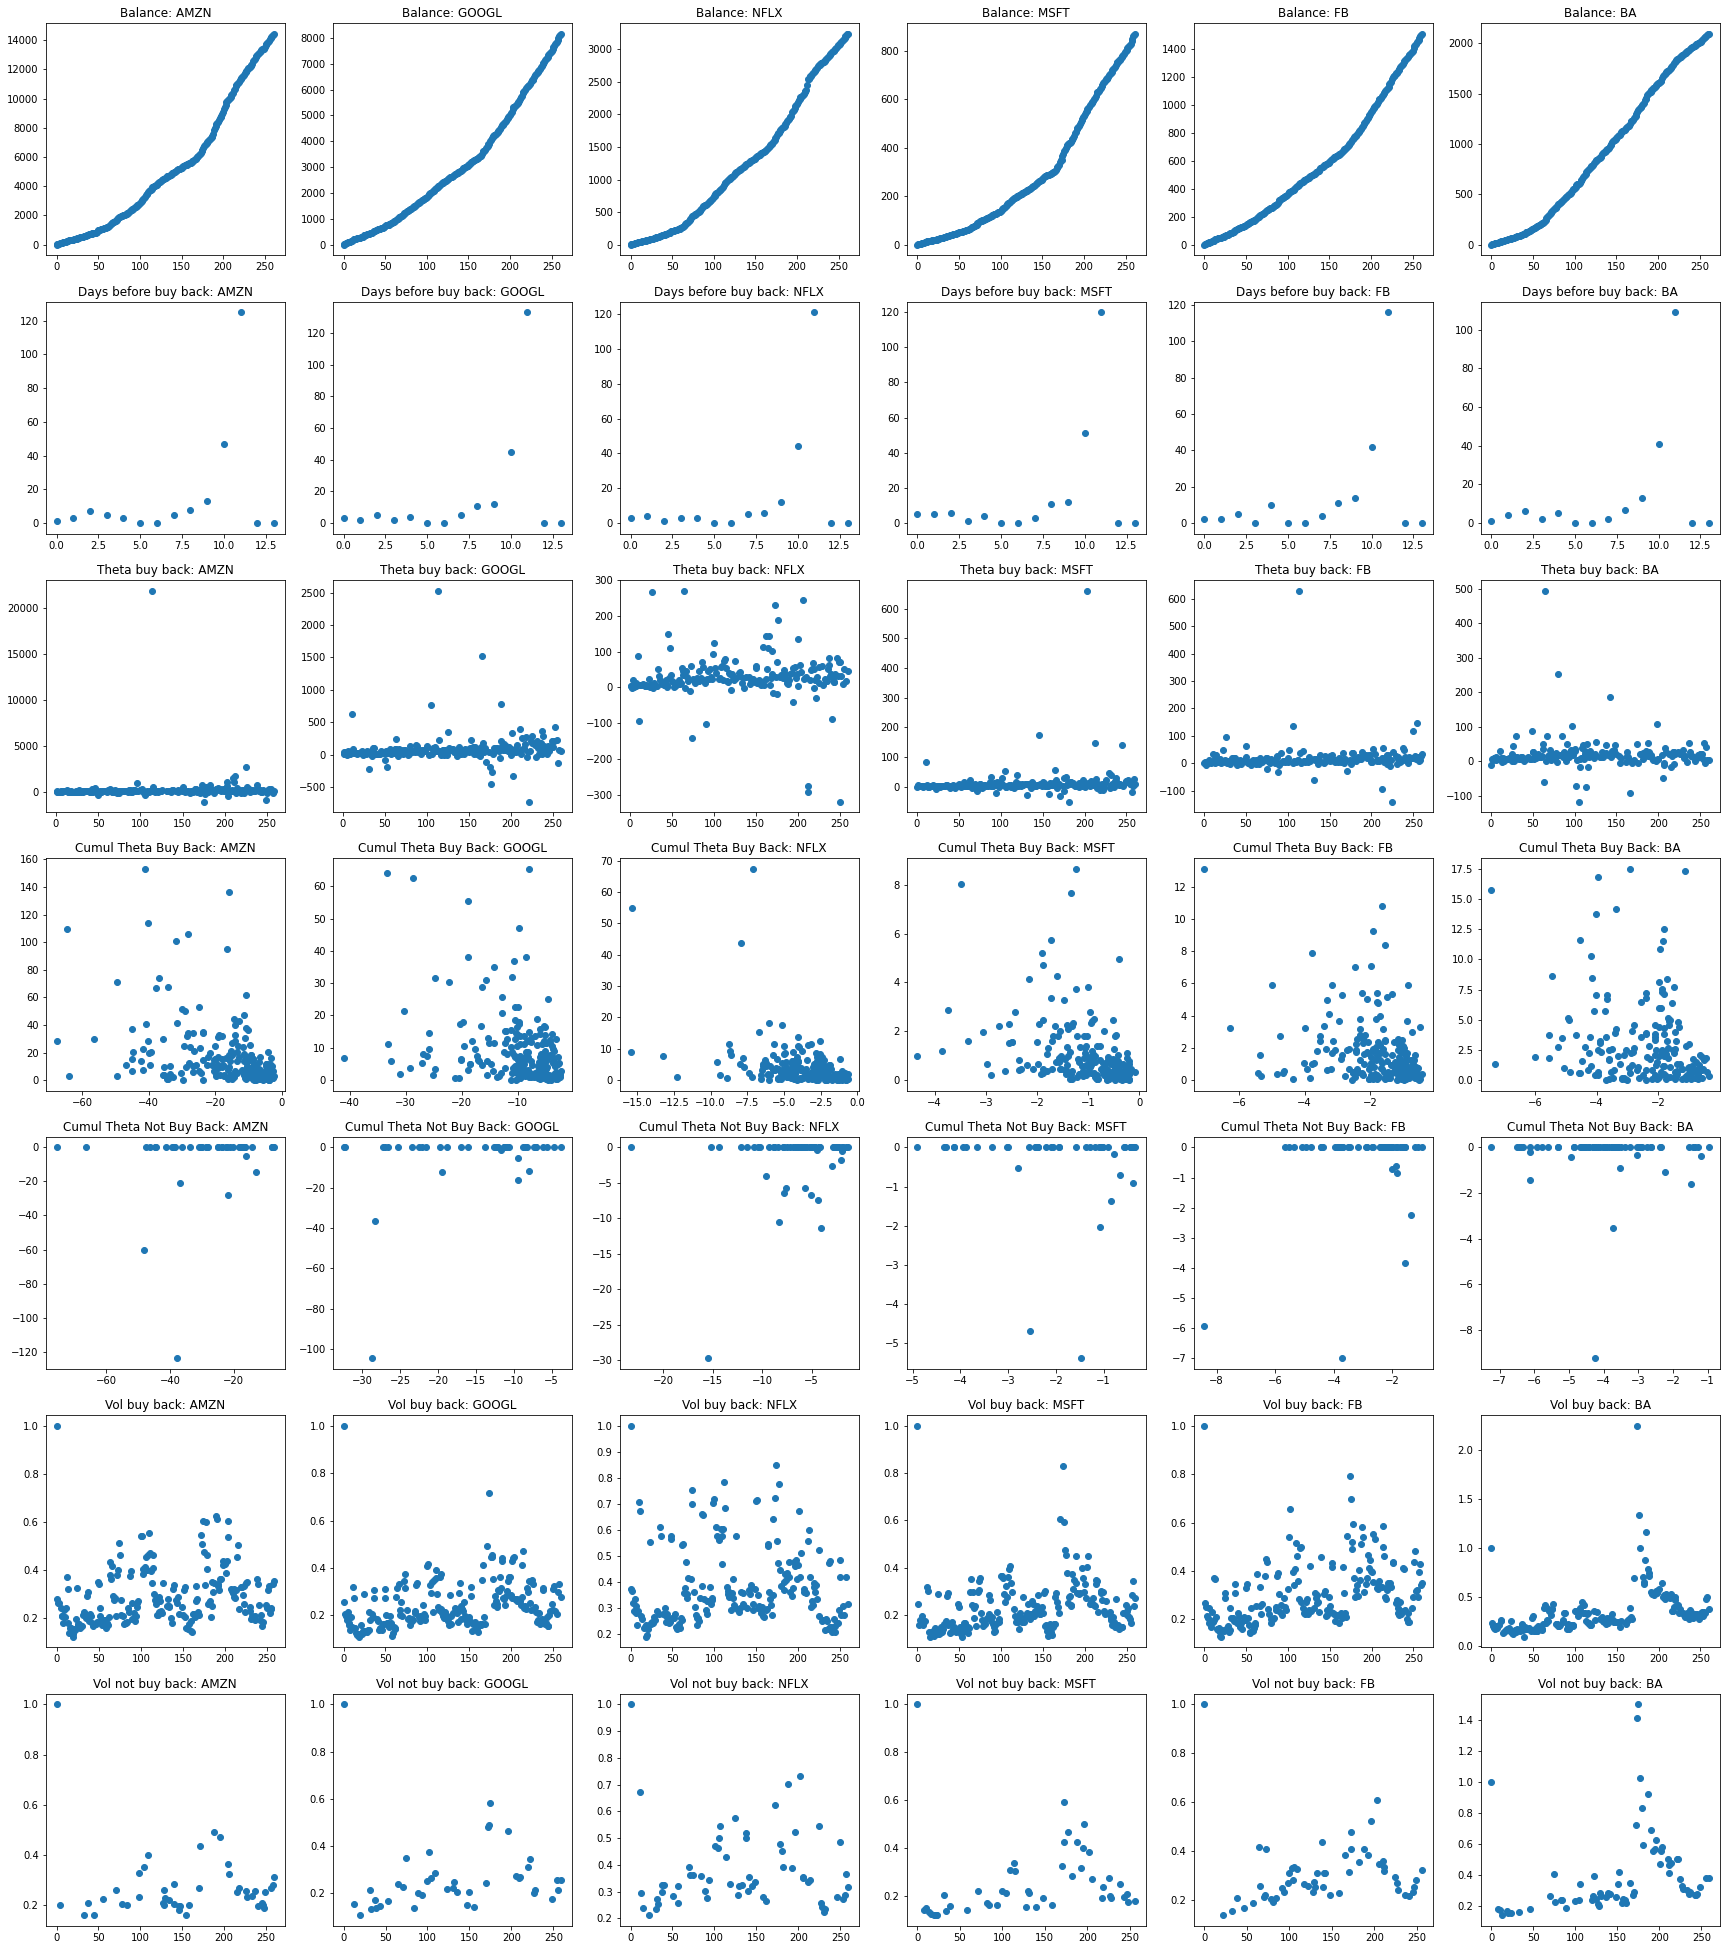

In [189]:
def visualize2(b: dict):
    columns = len(b)
    rows = len(list(b.values())[0])
    scale = 5

    fig, axs = plt.subplots(rows, columns)
    fig.set_figwidth(columns * scale)
    fig.set_figheight(rows * scale)
    i = 0
    for asset, values in b.items():
        j = 0
        for name, state in values.items():
            if type(state) is dict:
                lists = sorted(state.items())
                x, y = zip(*lists)
                axs[j, i].scatter(x, y)
                axs[j, i].set_title(f"{name}: {asset}")
            elif type(state) is list:
                axs[j, i].hlines(1,1,20)  # Draw a horizontal line
                axs[j, i].eventplot(state, orientation='horizontal', colors='b')
                axs[j, i].set_title(f"{name}: {asset}")
            j+=1
        i+=1
    plt.show()


visualize2(results)